# Singular Value Decomposition
Implement SVD given matrix A, and check its possible applications

In [33]:
import numpy as np
import matplotlib.pyplot as plt

Implement SVD of input matrix $A \in \mathbb{R}^{m \times n}$ at below method. As mentioned in the class, SVD consists of matrices composed of eigenvectors and square root of eigenvalues of $A^TA$ and $AA^T$. Here, non-zero singular values are square roots of the non-zero eigenvalues of $A^TA$ and $AA^T$. Use numpy.linalg.eig to get such values and compare the result with numpy.linalg.svd below.

* Be aware of the sign of eigenvectors! Sign of the eigenvectors of $A^TA$ and $AA^T$ should be coherent(They should match when transformed from one to another). Meaning When left singular vector $u_i$ is driven from $v_i$ by $u_i = Av_i$ (or right singular vector from left singular vector vice versa), the sign between transformed $u_i$ and the original left singular vector acquired by from np.linalg.eig(AA^T) should be the same. If they are different, flipping the sign of either one of them is required.  

* Singular values should be aligned in descending order.

* Other than using numpy elementary operations(numpy.concatenate, numpy.dot etc.) and np.linalg.eig, please ask if it isn't clear(you should not use numpy.linalg.svd!).

In [34]:
def SVD(A:np.array): # assume 2D array
  """
    input
    A : (h,w) sized numpy array
    output
    U : (h,h) sized numpy array
    Sig : (min(h,w), 1) sized numpy array
    V : (w,w) sized numpy array
  """
  A = A.astype(np.float32)
  U, V, Sig = None, None, None
  ########################################
  #------To Do : Fill here---------------#
  ########################################

  # Calculate the eigenvalues and eigenvectors of A^TA and AA^T
  eigenvalues_v, eigenvectors_v = np.linalg.eig(np.dot(A.T, A))
  eigenvalues_u, eigenvectors_u = np.linalg.eig(np.dot(A, A.T))

  # Sort the eigenvalues and eigen vectors of A^TA and AA^T in descending order
  sorted_v = np.argsort(eigenvalues_v)[::-1]
  sorted_u = np.argsort(eigenvalues_u)[::-1]

  eigenvectors_v = eigenvectors_v[:, sorted_v]
  eigenvectors_u = eigenvectors_u[:, sorted_u]

  # Calculate singular values
  Sig = np.sqrt(np.abs(eigenvalues_v[sorted_v]))

  # Calculate U and V
  U = eigenvectors_u
  V = eigenvectors_v

  # Match the signs
  for i in range(V.shape[1]): # Iterate through the coloumns of V
    u = np.dot(A, V[:, i]) # Calculate u
    if np.sign(u[0]) != np.sign(U[:, i][0]): # Sign check the first element
      U[:, i] = -U[:, i] # Flip the sign

  ########################################
  #------End of your Code----------------#
  ########################################
  return U, Sig, V.T

compare results with innate numpy method (check out for sign of column vectors in $U,V$)

In [35]:
# check L2 norm
def check_error(a:np.array, svd:SVD):
  u,s,v = np.linalg.svd(a)
  v = v.T
  u_impl, s_impl, v_impl = SVD(a)
  v_impl = v_impl.T
  H, W = a.shape
  error = 0.
  for h in range(H):
    if np.sign(u[:,h][0]) != np.sign(u_impl[:,h][0]):
      error += np.linalg.norm(u[:,h][0]+u_impl[:,h][0])
    else:
      error += np.linalg.norm(u[:,h][0]-u_impl[:,h][0])
  for w in range(W):
    if np.sign(v[:,w][0]) != np.sign(v_impl[:,w][0]):
      error += np.linalg.norm(v[:,w][0]+v_impl[:,w][0])
    else:
      error += np.linalg.norm(v[:,w][0]-v_impl[:,w][0])
  error += np.linalg.norm(s-s_impl)
  return error

# 1. Orthogonal Procrustes analysis

Orthogonal procrustes analysis is finding a $3 \times 3$ orthogonal matrix $\Omega^*$ that satiesfies  
$$ \Omega^* = \underset{\Omega \in \mathbb{R}^{3 \times 3}}{\text{argmin}}  \|A\Omega  - B\| $$
A and B can be random matrices but here, we will set them as pointclouds($A, B \in \mathbb{R}^{n \times 3}$). Then the problem would be fitting input pointcloud $A$ into target $B$ via transformation $\Omega$. Solving above with SVD will give you the solution.

In [42]:
!pip install trimesh
import trimesh
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

## Visualize input and target data

We are going to fit red points into blue points. Check the points are not aligned. You can swibble it around with cursor.

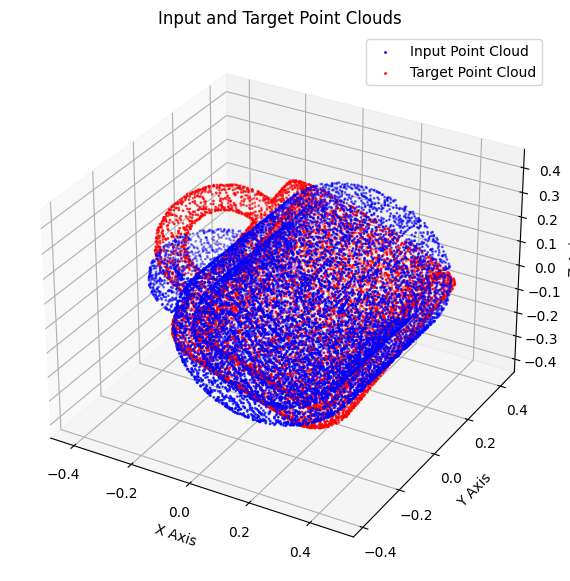

In [44]:
# choose the directory where you put your input cup pointcloud file
input_path = "./input.ply"
target_path = "./target.ply"
input_pcd = trimesh.load(input_path)
target_pcd = trimesh.load(target_path)
scene = trimesh.Scene([input_pcd, target_pcd])

# Use the following for interactive 3D scene rendering
# scene.show()

# Plotting  point clouds in a 3D scatter plot using Matplotlib to successfully export to Github
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting the input point cloud
ax.scatter(*input_pcd.vertices.T, color='blue', s=1, label='Input Point Cloud')

# Plotting the target point cloud
ax.scatter(*target_pcd.vertices.T, color='red', s=1, label='Target Point Cloud')

# Setting plot labels and title
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Input and Target Point Clouds')
ax.legend()

plt.show()

## Find transformation

* Note that you should use your implementation of SVD to find below transformations
* Don't worry even if they are not perfectly aligned. We will just check tendency of two separate pointclouds

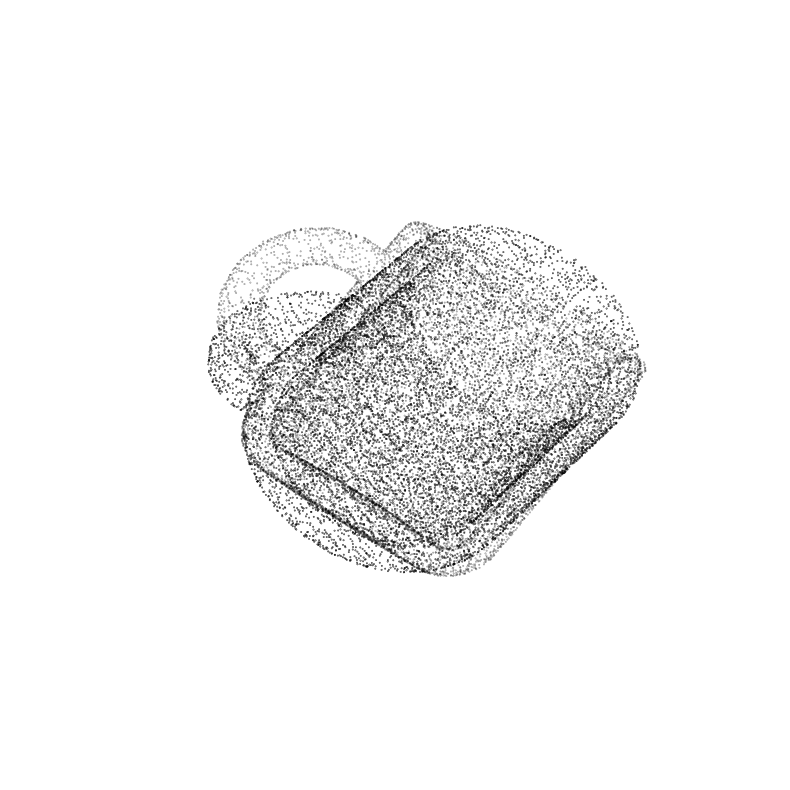

In [46]:
# find optimal transformation from input toward target
input_pts = np.array(input_pcd.vertices).T # nx3 array
target_pts = np.array(target_pcd.vertices).T # nx3 array
result_pts = None # should be nx3 array
########################################
#------To Do : Fill here---------------#
########################################

# Center the points
centroid_in = np.mean(input_pts, axis=1).reshape(-1, 1)
centroid_tar = np.mean(target_pts, axis=1).reshape(-1, 1)

centered_in = input_pts - centroid_in
centered_tar = target_pts - centroid_tar

# Calculate the covariance matrix (H)
H = np.dot(centered_in, centered_tar.T)

# Matrix decomposition using SVD
U, S, Vt = SVD(H)

# Calculate the rotation matrix (R)
R = np.dot(Vt.T, U.T)

# Calculate the translation vector (t)
t = centroid_tar - np.dot(R, centroid_in)

# Apply the transformation (rotation + translation)
result_pts = np.dot(R, input_pts) + t
result_pts = result_pts.T

########################################
#------End of your Code----------------#
########################################
result_pcd = trimesh.PointCloud(result_pts, colors=[0,1,0])

# visualize target data
scene = trimesh.Scene([target_pcd, result_pcd])

# Use the following for interactive 3D scene rendering
# scene.show()

# For Github rendeering
# Create a new figure for 3D plotting
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the input point cloud
ax.scatter(input_pcd.vertices[:, 0],  # X coordinates
           input_pcd.vertices[:, 1],  # Y coordinates
           input_pcd.vertices[:, 2],  # Z coordinates
           c='black',                 # Points color
           s=0.1,                     # Points size
           alpha=1.0)                 # Points transparency

# Scatter plot for the target point cloud
ax.scatter(target_pcd.vertices[:, 0],  # X coordinates
           target_pcd.vertices[:, 1],  # Y coordinates
           target_pcd.vertices[:, 2],  # Z coordinates
           c='black',                  # Points color
           s=0.1,                      # Points size
           alpha=0.5)                  # Points transparency

# Removing the axis
ax.axis('off')

# Show the plot
plt.show()


In [47]:
# check error
print("error is : {}".format(np.linalg.norm(result_pts-target_pts.T)))

error is : 4.057379633034222e-06


#2. Image compression

You can perform image compression with SVD. Reducing rank by setting from the largest singular value to smaller ones to zero will get the desired result. Reduce the number of ranks from 0 upto 9 (simply setting singular values 0 from the largest will do the work)



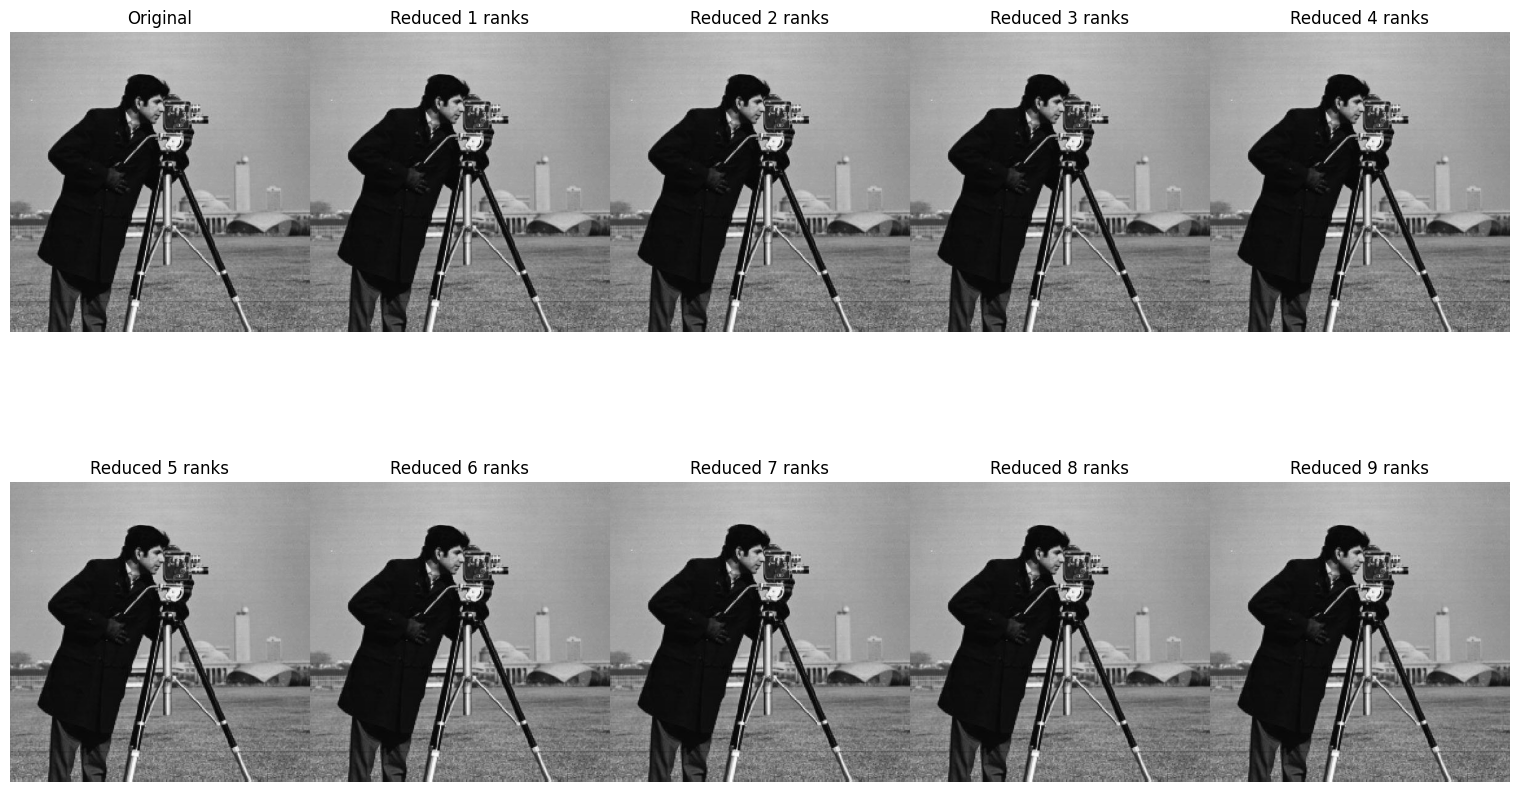

In [48]:
import cv2
import copy
original_img = cv2.imread("./cameraman.jpg", cv2.IMREAD_UNCHANGED)
original_img = original_img.astype(np.float32) # for precision change
num = 8
# compression and restore
def compress(Sigma, rank=0):
  ########################################
  #------To Do : Fill here---------------#
  ########################################

  # Set the smallest singular values to zero
  Sigma[-rank:] = 0

  ########################################
  #------End of your Code----------------#
  ########################################
  return Sigma

U, Sig, Vt = None, None, None
img_list = [] # list of images in numpy format
########################################
#------To Do : Fill here---------------#
########################################
U, Sig, Vt = SVD(original_img)

img_list = [original_img]

for rank in range(1, 10):  # Reduce the number of ranks from 0 to 9
  compressed_Sig = compress(copy.deepcopy(Sig), rank) # Compress the singular values
  reconst_img = np.dot(U, np.dot(np.diag(compressed_Sig), Vt)) # Restore the image
  img_list.append(reconst_img)
########################################
#------End of your Code----------------#
########################################

# Restore with different ranks(with different a)
gridspec_kw = {"wspace": 0.0, "hspace": 0.0}
fig, ax = plt.subplots(2, 5, gridspec_kw=gridspec_kw, figsize=(15, 9))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
for y in range(2):
    for x in range(5):
        idx = 5*y+x
          # original_img
        if idx == 0:
          ax[y][x].set_title("Original")
        else:
          ax[y][x].set_title("Reduced {} ranks".format(idx))
        ax[y][x].imshow(img_list[idx], cmap='gray')
        ax[y][x].set_axis_off()